We need statsmodels, tbats, orbit-ml, prophet
I am using statsforecast to load the airline passengers data

orbit-ml is quite big because of pyro and torch dependencies
orbit-ml caused a few problems when installing through pip; conda also gave me an error. Finally, this worked:

pip install orbit-ml --no-deps
pip install arviz 'pyro-ppl>=1.4.0' 

this doesn't work:
pip install 'pystan==2.19.1.1' 

but this:
pip install git+https://github.com/stan-dev/pystan2.git@1dd043db3c2618a9360a0f2ccbb57221634e5b08

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


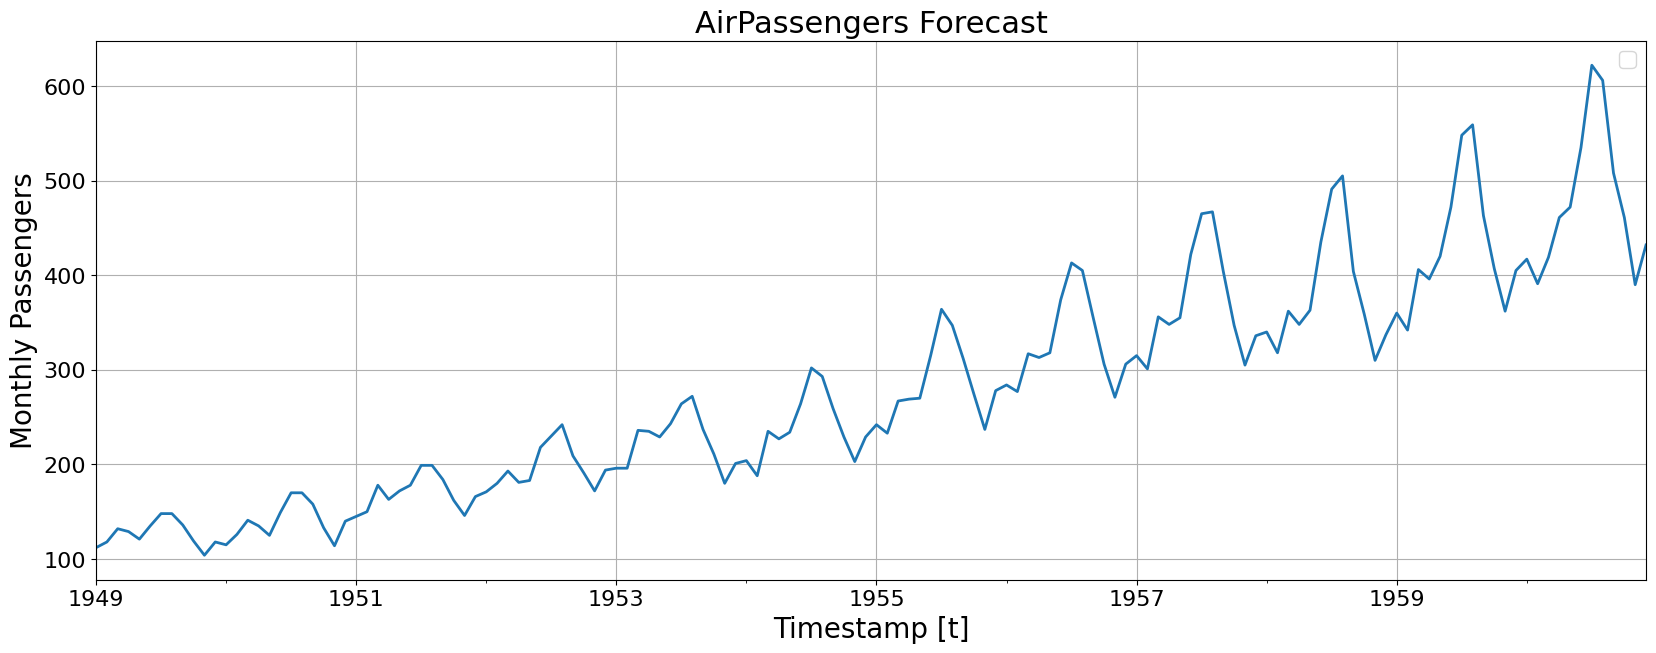

In [75]:
import pandas as pd

from statsforecast.utils import AirPassengersDF
import matplotlib.pyplot as plt


y = pd.Series(
    data=AirPassengersDF.y.values,
    index=pd.date_range("1949-01-01", end="1961-01-01", freq="M")
)
_, ax = plt.subplots(1, 1, figsize = (20, 7))
y.plot(ax=ax, linewidth=2)
ax.set_title('AirPassengers Forecast', fontsize=22)
ax.set_ylabel('Monthly Passengers', fontsize=20)
ax.set_xlabel('Timestamp [t]', fontsize=20)
ax.legend(prop={'size': 15})
ax.grid()

In [76]:
Y_train_df = y.head(132) # 132 monthly observations for train
Y_test_df = y.tail(12) # > 1959-12-31, 12 monthly observations for test

In [171]:
import numpy as np


def mae(y_hat, y_true):
    return np.mean(np.abs(y_hat-y_true))

def plot_forecast(fcast):
    """Plot the forecast.
    
    Also need y and Y_test_df here.
    """
    _, ax = plt.subplots(figsize=(15, 5))
    y.plot(ax=ax, style='r-')
    ax.axvline(x="1959-12")
    print(f"MAE: {mae(fcast['mean'].values, Y_test_df)}")
    fcast["mean"].plot(ax=ax, style='k--')
    ax.fill_between(fcast.index, fcast['mean_ci_lower'], fcast['mean_ci_upper'], color='k', alpha=0.1)


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.85378D+02    |proj g|=  1.82360D+02

At iterate    1    f=  7.78293D+00    |proj g|=  4.49238D+01

At iterate    2    f=  5.58573D+00    |proj g|=  9.26065D-01

At iterate    3    f=  5.58304D+00    |proj g|=  9.25134D-01

At iterate    4    f=  5.56895D+00    |proj g|=  1.79578D+00

At iterate    5    f=  5.53806D+00    |proj g|=  4.05671D+00

At iterate    6    f=  5.45263D+00    |proj g|=  7.03645D+00

At iterate    7    f=  5.26631D+00    |proj g|=  8.52759D+00

At iterate    8    f=  5.05776D+00    |proj g|=  6.53324D+00

At iterate    9    f=  4.99675D+00    |proj g|=  4.97304D+00

At iterate   10    f=  4.96003D+00    |proj g|=  3.93527D+00

At iterate   11    f=  4.89705D+00    |proj g|=  2.19533D+00

At iterate   12    f=  4.85862D+00    |proj g|=  2.56168D-02

At iterate   13    f=  4.8

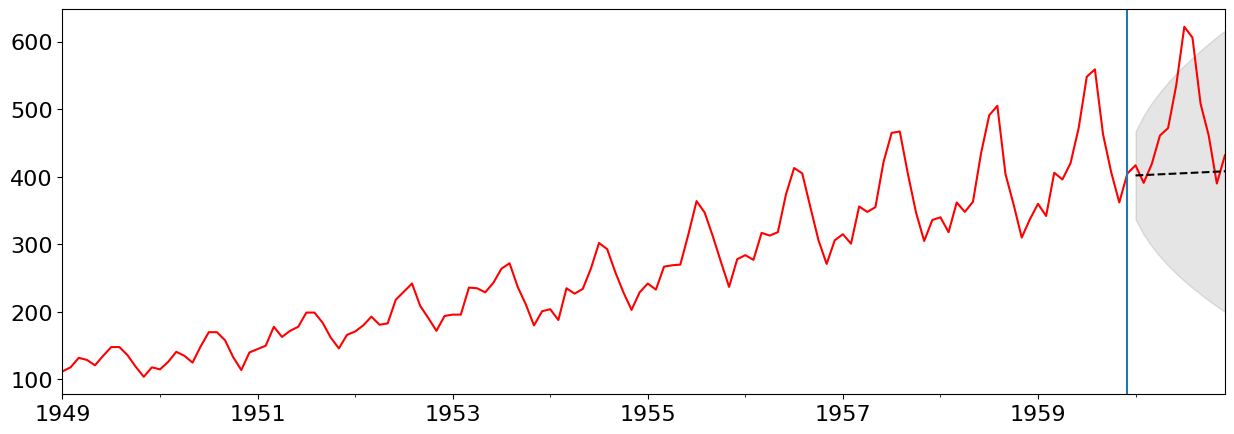

In [122]:
import statsmodels.api as sm

class KalmanFilter(sm.tsa.statespace.MLEModel):
    """Linear Kalman Filter Model.
    
    After https://github.com/statsmodels/statsmodels/issues/6148
    """
    def __init__(self, endog):
        # Model order
        k_states = k_posdef = 1

        # Initialize the statespace
        super(KalmanFilter, self).__init__(
            endog, k_states=k_states, k_posdef=k_posdef,
            initialization='approximate_diffuse',
            loglikelihood_burn=k_states
        )

        # Initialize the matrices
        self.ssm['design'] = np.array([1]) # Fix A to 1
        self.ssm['selection'] = np.eye(k_states)

        # Cache some indices
        self._state_cov_idx = ('state_cov',) + np.diag_indices(k_posdef)

    @property
    def param_names(self):
        return ['μ','T','G','H']

    @property
    def start_params(self):
        return [1, 2] + [np.std(self.endog)]*2

    def transform_params(self, unconstrained):
        return np.concatenate([unconstrained[:3], np.exp(unconstrained[3:])])

    def untransform_params(self, constrained):
        return np.concatenate([constrained[:3], np.log(constrained[3:])])

    def update(self, params, *args, **kwargs):
        params = super(KalmanFilter, self).update(params, *args, **kwargs)
        
        self.ssm['obs_intercept',0,0] = params[0]
        self.ssm['transition'] = np.array([[params[1]]])
        
        # Observation covariance
        self.ssm['obs_cov',0,0] = params[2]

        # State covariance
        self.ssm[self._state_cov_idx] = params[3]


mod = KalmanFilter(Y_train_df)
res = mod.fit(disp=True, maxiter=1000)
print(res.summary())

print(res.summary())
fcast = res.get_forecast(steps=12).summary_frame()
plot_forecast(res)

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.51160D+00    |proj g|=  1.29829D-01

At iterate    5    f=  4.35559D+00    |proj g|=  1.85355D-02

At iterate   10    f=  3.83177D+00    |proj g|=  8.08776D-01

At iterate   15    f=  3.58294D+00    |proj g|=  6.69769D-02

At iterate   20    f=  3.51908D+00    |proj g|=  3.61024D-02

At iterate   25    f=  3.51403D+00    |proj g|=  1.19528D-02

At iterate   30    f=  3.50999D+00    |proj g|=  3.34174D-02

At iterate   35    f=  3.50961D+00    |proj g|=  4.23258D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function 

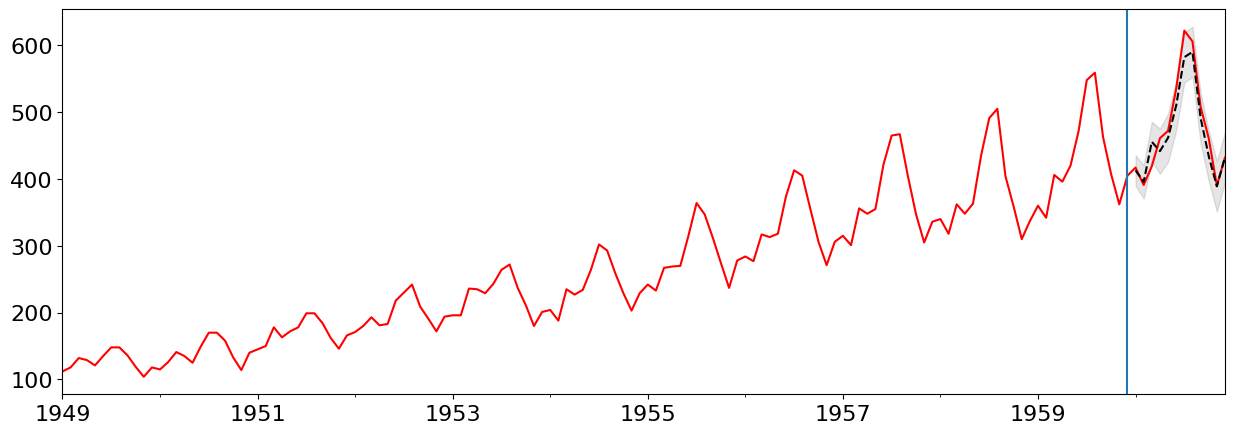

In [121]:
mod = sm.tsa.UnobservedComponents(Y_train_df, level=True, trend=True, seasonal=12, autoregressive=5)
res = mod.fit()
print(res.summary())
fcast = res.get_forecast(steps=12).summary_frame()
plot_forecast(res)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_aea89cc15436811b43e6c7a717ca27b7 NOW.
In file included from /var/folders/80/g9sqgdws2rn0yc3rd5y3nd340000gp/T/pystan_xf7ojozf/stanfit4anon_model_aea89cc15436811b43e6c7a717ca27b7_551934774583830596.cpp:836:
In file included from /opt/anaconda3/envs/book/lib/python3.10/site-packages/numpy/core/include/numpy/arrayobject.h:5:
In file included from /opt/anaconda3/envs/book/lib/python3.10/site-packages/numpy/core/include/numpy/ndarrayobject.h:12:
In file included from /opt/anaconda3/envs/book/lib/python3.10/site-packages/numpy/core/include/numpy/ndarraytypes.h:1960:
/opt/anaconda3/envs/book/lib/python3.10/site-packages/numpy/core/include/numpy/npy_1_7_deprecated_api.h:17:2: warning: "Using deprecated NumPy API, disable it with "          "#define NPY_NO_DEPRECATED_API NPY_1_7_API_VERSION" [-W#warnings]
#warning "Using deprecated NumPy API, disable it with " \
 ^
In file included from /var/folders/80/g9sqgdws2rn0yc3rd5y3nd340000gp/T/pysta

In file included from /var/folders/80/g9sqgdws2rn0yc3rd5y3nd340000gp/T/pystan_xf7ojozf/stanfit4anon_model_aea89cc15436811b43e6c7a717ca27b7_551934774583830596.cpp:845:
In file included from /opt/anaconda3/envs/book/lib/python3.10/site-packages/pystan/py_var_context.hpp:12:
In file included from /opt/anaconda3/envs/book/lib/python3.10/site-packages/pystan/stan/src/stan/io/dump.hpp:6:
In file included from /opt/anaconda3/envs/book/lib/python3.10/site-packages/pystan/stan/lib/stan_math/stan/math/prim/mat.hpp:9:
In file included from /opt/anaconda3/envs/book/lib/python3.10/site-packages/pystan/stan/lib/stan_math/stan/math/prim/mat/meta/as_array_or_scalar.hpp:4:
In file included from /opt/anaconda3/envs/book/lib/python3.10/site-packages/pystan/stan/lib/stan_math/lib/eigen_3.3.3/Eigen/Dense:1:
In file included from /opt/anaconda3/envs/book/lib/python3.10/site-packages/pystan/stan/lib/stan_math/lib/eigen_3.3.3/Eigen/Core:420:
/opt/anaconda3/envs/book/lib/python3.10/site-packages/pystan/stan/li

In file included from /var/folders/80/g9sqgdws2rn0yc3rd5y3nd340000gp/T/pystan_xf7ojozf/stanfit4anon_model_aea89cc15436811b43e6c7a717ca27b7_551934774583830596.cpp:845:
In file included from /opt/anaconda3/envs/book/lib/python3.10/site-packages/pystan/py_var_context.hpp:12:
In file included from /opt/anaconda3/envs/book/lib/python3.10/site-packages/pystan/stan/src/stan/io/dump.hpp:6:
In file included from /opt/anaconda3/envs/book/lib/python3.10/site-packages/pystan/stan/lib/stan_math/stan/math/prim/mat.hpp:9:
In file included from /opt/anaconda3/envs/book/lib/python3.10/site-packages/pystan/stan/lib/stan_math/stan/math/prim/mat/meta/as_array_or_scalar.hpp:4:
In file included from /opt/anaconda3/envs/book/lib/python3.10/site-packages/pystan/stan/lib/stan_math/lib/eigen_3.3.3/Eigen/Dense:1:
In file included from /opt/anaconda3/envs/book/lib/python3.10/site-packages/pystan/stan/lib/stan_math/lib/eigen_3.3.3/Eigen/Core:420:
/opt/anaconda3/envs/book/lib/python3.10/site-packages/pystan/stan/li

In file included from /var/folders/80/g9sqgdws2rn0yc3rd5y3nd340000gp/T/pystan_xf7ojozf/stanfit4anon_model_aea89cc15436811b43e6c7a717ca27b7_551934774583830596.cpp:845:
In file included from /opt/anaconda3/envs/book/lib/python3.10/site-packages/pystan/py_var_context.hpp:12:
In file included from /opt/anaconda3/envs/book/lib/python3.10/site-packages/pystan/stan/src/stan/io/dump.hpp:6:
In file included from /opt/anaconda3/envs/book/lib/python3.10/site-packages/pystan/stan/lib/stan_math/stan/math/prim/mat.hpp:9:
In file included from /opt/anaconda3/envs/book/lib/python3.10/site-packages/pystan/stan/lib/stan_math/stan/math/prim/mat/meta/as_array_or_scalar.hpp:4:
In file included from /opt/anaconda3/envs/book/lib/python3.10/site-packages/pystan/stan/lib/stan_math/lib/eigen_3.3.3/Eigen/Dense:1:
In file included from /opt/anaconda3/envs/book/lib/python3.10/site-packages/pystan/stan/lib/stan_math/lib/eigen_3.3.3/Eigen/Core:420:
/opt/anaconda3/envs/book/lib/python3.10/site-packages/pystan/stan/li

In file included from /var/folders/80/g9sqgdws2rn0yc3rd5y3nd340000gp/T/pystan_xf7ojozf/stanfit4anon_model_aea89cc15436811b43e6c7a717ca27b7_551934774583830596.cpp:846:
In file included from /opt/anaconda3/envs/book/lib/python3.10/site-packages/pystan/stan_fit.hpp:15:
In file included from /opt/anaconda3/envs/book/lib/python3.10/site-packages/pystan/stan/lib/stan_math/lib/boost_1.69.0/boost/random/additive_combine.hpp:27:
/opt/anaconda3/envs/book/lib/python3.10/site-packages/pystan/stan/lib/stan_math/lib/boost_1.69.0/boost/random/linear_congruential.hpp:140:20: warning: overlapping comparisons always evaluate to false [-Wtautological-overlap-compare]
        if(_x <= 0 && _x != 0) {
           ~~~~~~~~^~~~~~~~~~
/opt/anaconda3/envs/book/lib/python3.10/site-packages/pystan/stan/lib/stan_math/lib/boost_1.69.0/boost/random/linear_congruential.hpp:393:11: note: in instantiation of member function 'boost::random::linear_congruential_engine<unsigned long long, 25214903917, 11, 281474976710656>

In file included from /var/folders/80/g9sqgdws2rn0yc3rd5y3nd340000gp/T/pystan_xf7ojozf/stanfit4anon_model_aea89cc15436811b43e6c7a717ca27b7_551934774583830596.cpp:845:
In file included from /opt/anaconda3/envs/book/lib/python3.10/site-packages/pystan/py_var_context.hpp:12:
In file included from /opt/anaconda3/envs/book/lib/python3.10/site-packages/pystan/stan/src/stan/io/dump.hpp:6:
In file included from /opt/anaconda3/envs/book/lib/python3.10/site-packages/pystan/stan/lib/stan_math/stan/math/prim/mat.hpp:9:
In file included from /opt/anaconda3/envs/book/lib/python3.10/site-packages/pystan/stan/lib/stan_math/stan/math/prim/mat/meta/as_array_or_scalar.hpp:4:
In file included from /opt/anaconda3/envs/book/lib/python3.10/site-packages/pystan/stan/lib/stan_math/lib/eigen_3.3.3/Eigen/Dense:1:
In file included from /opt/anaconda3/envs/book/lib/python3.10/site-packages/pystan/stan/lib/stan_math/lib/eigen_3.3.3/Eigen/Core:420:
/opt/anaconda3/envs/book/lib/python3.10/site-packages/pystan/stan/li

In file included from /var/folders/80/g9sqgdws2rn0yc3rd5y3nd340000gp/T/pystan_xf7ojozf/stanfit4anon_model_aea89cc15436811b43e6c7a717ca27b7_551934774583830596.cpp:845:
In file included from /opt/anaconda3/envs/book/lib/python3.10/site-packages/pystan/py_var_context.hpp:12:
In file included from /opt/anaconda3/envs/book/lib/python3.10/site-packages/pystan/stan/src/stan/io/dump.hpp:6:
In file included from /opt/anaconda3/envs/book/lib/python3.10/site-packages/pystan/stan/lib/stan_math/stan/math/prim/mat.hpp:9:
In file included from /opt/anaconda3/envs/book/lib/python3.10/site-packages/pystan/stan/lib/stan_math/stan/math/prim/mat/meta/as_array_or_scalar.hpp:4:
In file included from /opt/anaconda3/envs/book/lib/python3.10/site-packages/pystan/stan/lib/stan_math/lib/eigen_3.3.3/Eigen/Dense:1:
In file included from /opt/anaconda3/envs/book/lib/python3.10/site-packages/pystan/stan/lib/stan_math/lib/eigen_3.3.3/Eigen/Core:420:
/opt/anaconda3/envs/book/lib/python3.10/site-packages/pystan/stan/li

In file included from /var/folders/80/g9sqgdws2rn0yc3rd5y3nd340000gp/T/pystan_xf7ojozf/stanfit4anon_model_aea89cc15436811b43e6c7a717ca27b7_551934774583830596.cpp:845:
In file included from /opt/anaconda3/envs/book/lib/python3.10/site-packages/pystan/py_var_context.hpp:12:
In file included from /opt/anaconda3/envs/book/lib/python3.10/site-packages/pystan/stan/src/stan/io/dump.hpp:6:
In file included from /opt/anaconda3/envs/book/lib/python3.10/site-packages/pystan/stan/lib/stan_math/stan/math/prim/mat.hpp:9:
In file included from /opt/anaconda3/envs/book/lib/python3.10/site-packages/pystan/stan/lib/stan_math/stan/math/prim/mat/meta/as_array_or_scalar.hpp:4:
In file included from /opt/anaconda3/envs/book/lib/python3.10/site-packages/pystan/stan/lib/stan_math/lib/eigen_3.3.3/Eigen/Dense:1:
In file included from /opt/anaconda3/envs/book/lib/python3.10/site-packages/pystan/stan/lib/stan_math/lib/eigen_3.3.3/Eigen/Core:420:
/opt/anaconda3/envs/book/lib/python3.10/site-packages/pystan/stan/li

In file included from /var/folders/80/g9sqgdws2rn0yc3rd5y3nd340000gp/T/pystan_xf7ojozf/stanfit4anon_model_aea89cc15436811b43e6c7a717ca27b7_551934774583830596.cpp:845:
In file included from /opt/anaconda3/envs/book/lib/python3.10/site-packages/pystan/py_var_context.hpp:12:
In file included from /opt/anaconda3/envs/book/lib/python3.10/site-packages/pystan/stan/src/stan/io/dump.hpp:6:
In file included from /opt/anaconda3/envs/book/lib/python3.10/site-packages/pystan/stan/lib/stan_math/stan/math/prim/mat.hpp:9:
In file included from /opt/anaconda3/envs/book/lib/python3.10/site-packages/pystan/stan/lib/stan_math/stan/math/prim/mat/meta/as_array_or_scalar.hpp:4:
In file included from /opt/anaconda3/envs/book/lib/python3.10/site-packages/pystan/stan/lib/stan_math/lib/eigen_3.3.3/Eigen/Dense:1:
In file included from /opt/anaconda3/envs/book/lib/python3.10/site-packages/pystan/stan/lib/stan_math/lib/eigen_3.3.3/Eigen/Core:420:
/opt/anaconda3/envs/book/lib/python3.10/site-packages/pystan/stan/li

In file included from /var/folders/80/g9sqgdws2rn0yc3rd5y3nd340000gp/T/pystan_xf7ojozf/stanfit4anon_model_aea89cc15436811b43e6c7a717ca27b7_551934774583830596.cpp:845:
In file included from /opt/anaconda3/envs/book/lib/python3.10/site-packages/pystan/py_var_context.hpp:12:
In file included from /opt/anaconda3/envs/book/lib/python3.10/site-packages/pystan/stan/src/stan/io/dump.hpp:6:
In file included from /opt/anaconda3/envs/book/lib/python3.10/site-packages/pystan/stan/lib/stan_math/stan/math/prim/mat.hpp:9:
In file included from /opt/anaconda3/envs/book/lib/python3.10/site-packages/pystan/stan/lib/stan_math/stan/math/prim/mat/meta/as_array_or_scalar.hpp:4:
In file included from /opt/anaconda3/envs/book/lib/python3.10/site-packages/pystan/stan/lib/stan_math/lib/eigen_3.3.3/Eigen/Dense:1:
In file included from /opt/anaconda3/envs/book/lib/python3.10/site-packages/pystan/stan/lib/stan_math/lib/eigen_3.3.3/Eigen/Core:420:
/opt/anaconda3/envs/book/lib/python3.10/site-packages/pystan/stan/li

In file included from /var/folders/80/g9sqgdws2rn0yc3rd5y3nd340000gp/T/pystan_xf7ojozf/stanfit4anon_model_aea89cc15436811b43e6c7a717ca27b7_551934774583830596.cpp:845:
In file included from /opt/anaconda3/envs/book/lib/python3.10/site-packages/pystan/py_var_context.hpp:12:
In file included from /opt/anaconda3/envs/book/lib/python3.10/site-packages/pystan/stan/src/stan/io/dump.hpp:6:
In file included from /opt/anaconda3/envs/book/lib/python3.10/site-packages/pystan/stan/lib/stan_math/stan/math/prim/mat.hpp:9:
In file included from /opt/anaconda3/envs/book/lib/python3.10/site-packages/pystan/stan/lib/stan_math/stan/math/prim/mat/meta/as_array_or_scalar.hpp:4:
In file included from /opt/anaconda3/envs/book/lib/python3.10/site-packages/pystan/stan/lib/stan_math/lib/eigen_3.3.3/Eigen/Dense:1:
In file included from /opt/anaconda3/envs/book/lib/python3.10/site-packages/pystan/stan/lib/stan_math/lib/eigen_3.3.3/Eigen/Core:420:
/opt/anaconda3/envs/book/lib/python3.10/site-packages/pystan/stan/li

In file included from /var/folders/80/g9sqgdws2rn0yc3rd5y3nd340000gp/T/pystan_xf7ojozf/stanfit4anon_model_aea89cc15436811b43e6c7a717ca27b7_551934774583830596.cpp:845:
In file included from /opt/anaconda3/envs/book/lib/python3.10/site-packages/pystan/py_var_context.hpp:12:
In file included from /opt/anaconda3/envs/book/lib/python3.10/site-packages/pystan/stan/src/stan/io/dump.hpp:6:
In file included from /opt/anaconda3/envs/book/lib/python3.10/site-packages/pystan/stan/lib/stan_math/stan/math/prim/mat.hpp:9:
In file included from /opt/anaconda3/envs/book/lib/python3.10/site-packages/pystan/stan/lib/stan_math/stan/math/prim/mat/meta/as_array_or_scalar.hpp:4:
In file included from /opt/anaconda3/envs/book/lib/python3.10/site-packages/pystan/stan/lib/stan_math/lib/eigen_3.3.3/Eigen/Dense:1:
In file included from /opt/anaconda3/envs/book/lib/python3.10/site-packages/pystan/stan/lib/stan_math/lib/eigen_3.3.3/Eigen/Core:420:
/opt/anaconda3/envs/book/lib/python3.10/site-packages/pystan/stan/li

    MayLinearVectorize = bool(MightVectorize) && MayLinearize && DstHasDirectAccess
                                                              ^
/opt/anaconda3/envs/book/lib/python3.10/site-packages/pystan/stan/lib/stan_math/lib/eigen_3.3.3/Eigen/src/Core/AssignEvaluator.h:607:20: note: in instantiation of template class 'Eigen::internal::copy_using_evaluator_traits<Eigen::internal::evaluator<Eigen::Matrix<double, -1, 1, 0>>, Eigen::internal::evaluator<Eigen::CwiseBinaryOp<Eigen::internal::scalar_sum_op<double>, const Eigen::CwiseBinaryOp<Eigen::internal::scalar_product_op<double>, const Eigen::CwiseNullaryOp<Eigen::internal::scalar_constant_op<double>, const Eigen::Matrix<double, -1, 1, 0>>, const Eigen::Matrix<double, -1, 1, 0>>, const Eigen::CwiseBinaryOp<Eigen::internal::scalar_product_op<double>, const Eigen::CwiseNullaryOp<Eigen::internal::scalar_constant_op<double>, const Eigen::Matrix<double, -1, 1, 0>>, const Eigen::CwiseNullaryOp<Eigen::internal::scalar_constant_op<double>

In file included from /var/folders/80/g9sqgdws2rn0yc3rd5y3nd340000gp/T/pystan_xf7ojozf/stanfit4anon_model_aea89cc15436811b43e6c7a717ca27b7_551934774583830596.cpp:845:
In file included from /opt/anaconda3/envs/book/lib/python3.10/site-packages/pystan/py_var_context.hpp:12:
In file included from /opt/anaconda3/envs/book/lib/python3.10/site-packages/pystan/stan/src/stan/io/dump.hpp:6:
In file included from /opt/anaconda3/envs/book/lib/python3.10/site-packages/pystan/stan/lib/stan_math/stan/math/prim/mat.hpp:9:
In file included from /opt/anaconda3/envs/book/lib/python3.10/site-packages/pystan/stan/lib/stan_math/stan/math/prim/mat/meta/as_array_or_scalar.hpp:4:
In file included from /opt/anaconda3/envs/book/lib/python3.10/site-packages/pystan/stan/lib/stan_math/lib/eigen_3.3.3/Eigen/Dense:1:
In file included from /opt/anaconda3/envs/book/lib/python3.10/site-packages/pystan/stan/lib/stan_math/lib/eigen_3.3.3/Eigen/Core:420:
/opt/anaconda3/envs/book/lib/python3.10/site-packages/pystan/stan/li

In file included from /var/folders/80/g9sqgdws2rn0yc3rd5y3nd340000gp/T/pystan_xf7ojozf/stanfit4anon_model_aea89cc15436811b43e6c7a717ca27b7_551934774583830596.cpp:845:
In file included from /opt/anaconda3/envs/book/lib/python3.10/site-packages/pystan/py_var_context.hpp:12:
In file included from /opt/anaconda3/envs/book/lib/python3.10/site-packages/pystan/stan/src/stan/io/dump.hpp:6:
In file included from /opt/anaconda3/envs/book/lib/python3.10/site-packages/pystan/stan/lib/stan_math/stan/math/prim/mat.hpp:9:
In file included from /opt/anaconda3/envs/book/lib/python3.10/site-packages/pystan/stan/lib/stan_math/stan/math/prim/mat/meta/as_array_or_scalar.hpp:4:
In file included from /opt/anaconda3/envs/book/lib/python3.10/site-packages/pystan/stan/lib/stan_math/lib/eigen_3.3.3/Eigen/Dense:1:
In file included from /opt/anaconda3/envs/book/lib/python3.10/site-packages/pystan/stan/lib/stan_math/lib/eigen_3.3.3/Eigen/Core:420:
/opt/anaconda3/envs/book/lib/python3.10/site-packages/pystan/stan/li

In file included from /var/folders/80/g9sqgdws2rn0yc3rd5y3nd340000gp/T/pystan_xf7ojozf/stanfit4anon_model_aea89cc15436811b43e6c7a717ca27b7_551934774583830596.cpp:845:
In file included from /opt/anaconda3/envs/book/lib/python3.10/site-packages/pystan/py_var_context.hpp:12:
In file included from /opt/anaconda3/envs/book/lib/python3.10/site-packages/pystan/stan/src/stan/io/dump.hpp:6:
In file included from /opt/anaconda3/envs/book/lib/python3.10/site-packages/pystan/stan/lib/stan_math/stan/math/prim/mat.hpp:9:
In file included from /opt/anaconda3/envs/book/lib/python3.10/site-packages/pystan/stan/lib/stan_math/stan/math/prim/mat/meta/as_array_or_scalar.hpp:4:
In file included from /opt/anaconda3/envs/book/lib/python3.10/site-packages/pystan/stan/lib/stan_math/lib/eigen_3.3.3/Eigen/Dense:1:
In file included from /opt/anaconda3/envs/book/lib/python3.10/site-packages/pystan/stan/lib/stan_math/lib/eigen_3.3.3/Eigen/Core:420:
/opt/anaconda3/envs/book/lib/python3.10/site-packages/pystan/stan/li

In file included from /var/folders/80/g9sqgdws2rn0yc3rd5y3nd340000gp/T/pystan_xf7ojozf/stanfit4anon_model_aea89cc15436811b43e6c7a717ca27b7_551934774583830596.cpp:845:
In file included from /opt/anaconda3/envs/book/lib/python3.10/site-packages/pystan/py_var_context.hpp:12:
In file included from /opt/anaconda3/envs/book/lib/python3.10/site-packages/pystan/stan/src/stan/io/dump.hpp:6:
In file included from /opt/anaconda3/envs/book/lib/python3.10/site-packages/pystan/stan/lib/stan_math/stan/math/prim/mat.hpp:9:
In file included from /opt/anaconda3/envs/book/lib/python3.10/site-packages/pystan/stan/lib/stan_math/stan/math/prim/mat/meta/as_array_or_scalar.hpp:4:
In file included from /opt/anaconda3/envs/book/lib/python3.10/site-packages/pystan/stan/lib/stan_math/lib/eigen_3.3.3/Eigen/Dense:1:
In file included from /opt/anaconda3/envs/book/lib/python3.10/site-packages/pystan/stan/lib/stan_math/lib/eigen_3.3.3/Eigen/Core:420:
/opt/anaconda3/envs/book/lib/python3.10/site-packages/pystan/stan/li

In file included from /var/folders/80/g9sqgdws2rn0yc3rd5y3nd340000gp/T/pystan_xf7ojozf/stanfit4anon_model_aea89cc15436811b43e6c7a717ca27b7_551934774583830596.cpp:845:
In file included from /opt/anaconda3/envs/book/lib/python3.10/site-packages/pystan/py_var_context.hpp:12:
In file included from /opt/anaconda3/envs/book/lib/python3.10/site-packages/pystan/stan/src/stan/io/dump.hpp:6:
In file included from /opt/anaconda3/envs/book/lib/python3.10/site-packages/pystan/stan/lib/stan_math/stan/math/prim/mat.hpp:9:
In file included from /opt/anaconda3/envs/book/lib/python3.10/site-packages/pystan/stan/lib/stan_math/stan/math/prim/mat/meta/as_array_or_scalar.hpp:4:
In file included from /opt/anaconda3/envs/book/lib/python3.10/site-packages/pystan/stan/lib/stan_math/lib/eigen_3.3.3/Eigen/Dense:1:
In file included from /opt/anaconda3/envs/book/lib/python3.10/site-packages/pystan/stan/lib/stan_math/lib/eigen_3.3.3/Eigen/Core:420:
/opt/anaconda3/envs/book/lib/python3.10/site-packages/pystan/stan/li

In file included from /var/folders/80/g9sqgdws2rn0yc3rd5y3nd340000gp/T/pystan_xf7ojozf/stanfit4anon_model_aea89cc15436811b43e6c7a717ca27b7_551934774583830596.cpp:845:
In file included from /opt/anaconda3/envs/book/lib/python3.10/site-packages/pystan/py_var_context.hpp:12:
In file included from /opt/anaconda3/envs/book/lib/python3.10/site-packages/pystan/stan/src/stan/io/dump.hpp:6:
In file included from /opt/anaconda3/envs/book/lib/python3.10/site-packages/pystan/stan/lib/stan_math/stan/math/prim/mat.hpp:9:
In file included from /opt/anaconda3/envs/book/lib/python3.10/site-packages/pystan/stan/lib/stan_math/stan/math/prim/mat/meta/as_array_or_scalar.hpp:4:
In file included from /opt/anaconda3/envs/book/lib/python3.10/site-packages/pystan/stan/lib/stan_math/lib/eigen_3.3.3/Eigen/Dense:1:
In file included from /opt/anaconda3/envs/book/lib/python3.10/site-packages/pystan/stan/lib/stan_math/lib/eigen_3.3.3/Eigen/Core:420:
/opt/anaconda3/envs/book/lib/python3.10/site-packages/pystan/stan/li

156 warnings generated.
INFO:orbit:Sampling (PyStan) with chains: 4, cores: 4, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.


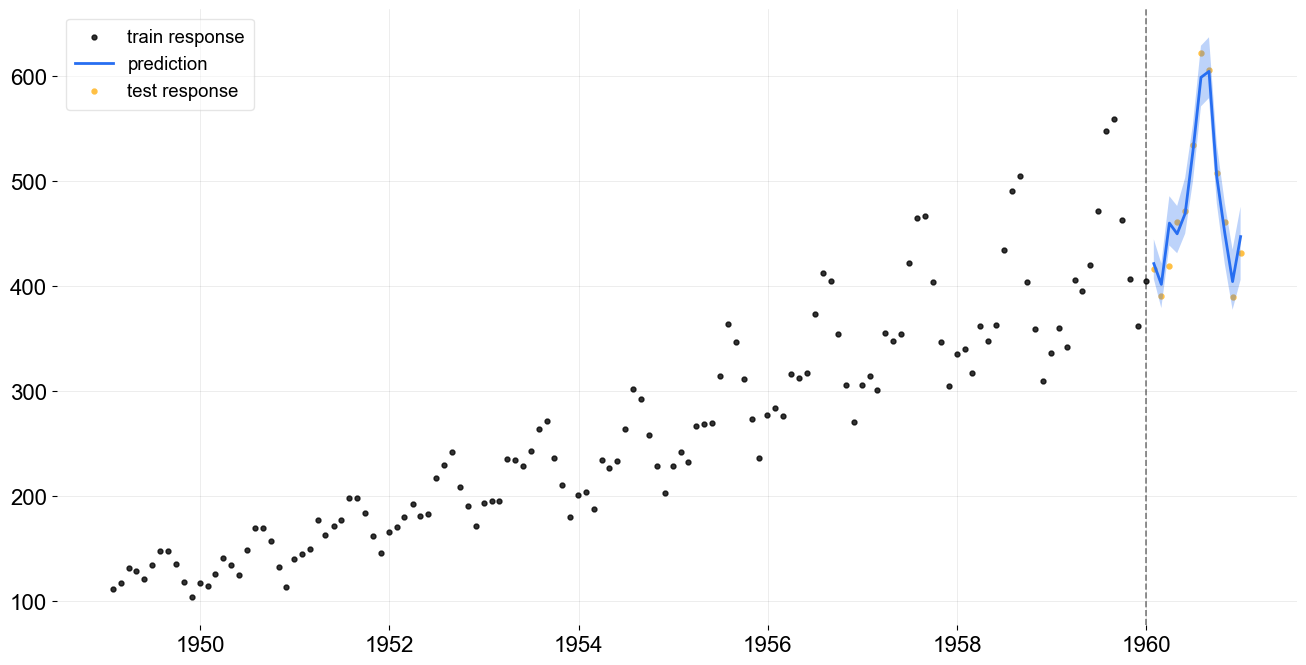

<AxesSubplot: >

In [207]:
from orbit.models import LGT
from orbit.diagnostics.plot import plot_predicted_data


train = Y_train_df.to_frame(name="y").reset_index()
test = Y_test_df.to_frame(name="y").reset_index()

dlt = LGT(
  response_col='y', date_col='index',
  seasonality=12,
)
dlt.fit(df=train)

predicted_df = dlt.predict(df=test)

plot_predicted_data(
  training_actual_df=train, predicted_df=predicted_df,
  date_col="index", actual_col="y",
  test_actual_df=test
)

In [210]:
mae(predicted_df.prediction, test.y)

12.041326585511783

In [145]:
# very slow... 
from tbats import TBATS
import numpy as np


estimator = TBATS(
    use_box_cox=True,
    use_arma_errors=True,
    seasonal_periods=[12],
)

fitted_model = estimator.fit(Y_train_df)
y_forecasted, confidence_info = fitted_model.forecast(steps=12, confidence_level=0.95)
print(fitted_model.summary())

Use Box-Cox: True
Use trend: True
Use damped trend: False
Seasonal periods: [12.]
Seasonal harmonics [5]
ARMA errors (p, q): (0, 0)
Box-Cox Lambda 0.000000
Smoothing (Alpha): 0.779622
Trend (Beta): 0.038266
Damping Parameter (Phi): 1.000000
Seasonal Parameters (Gamma): [-2.69597037e-07  1.83727002e-08]
AR coefficients []
MA coefficients []
Seed vector [ 4.80947285 -0.00826982 -0.14591517  0.0550767  -0.01029949  0.00853503
  0.00593837  0.0294945   0.06086945 -0.02716354 -0.03377025 -0.02173201]

AIC 1248.616522


MAE: 15.296747006044876


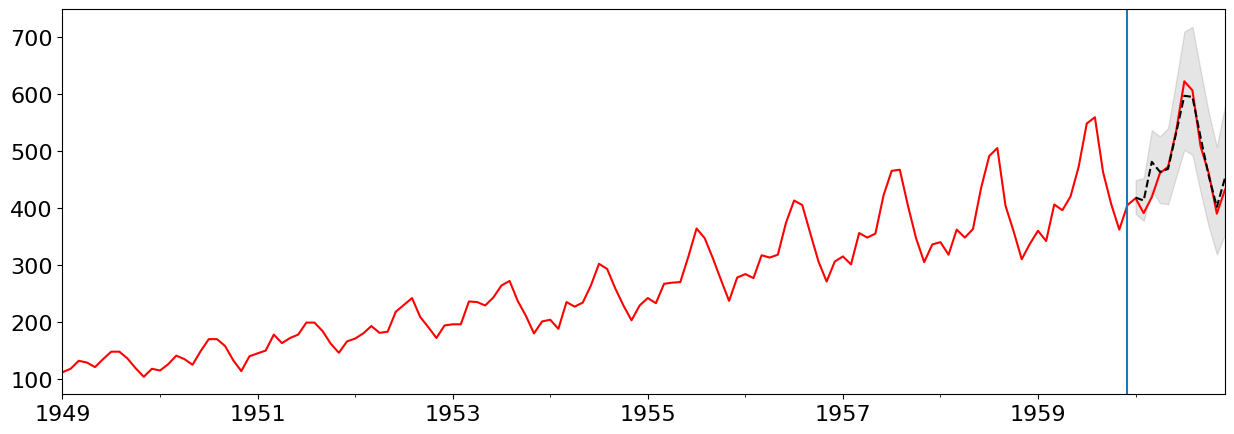

In [203]:
tbat_forecast = pd.DataFrame(
    data=confidence_info,
    index=y.tail(12).index
).rename(columns={"lower_bound": "mean_ci_lower", "upper_bound": "mean_ci_upper"})
plot_forecast(tbat_forecast)

In [151]:
from prophet import Prophet

train = Y_train_df.to_frame(name="y").reset_index().rename(columns={"index": "ds"})
test = Y_test_df.to_frame(name="y").reset_index().rename(columns={"index": "ds"})

m = Prophet()
m.fit(train)
future = m.make_future_dataframe(periods=12)
forecast = m.predict(future)

21:32:59 - cmdstanpy - INFO - Chain [1] start processing
21:32:59 - cmdstanpy - INFO - Chain [1] done processing


,ds,yhat,yhat_lower,yhat_upper
139,1960-01-08,401.036162,377.813254,427.358888
140,1960-01-09,405.376386,380.464239,430.222178
141,1960-01-10,410.811719,385.741159,436.015449
142,1960-01-11,417.162020,390.662689,442.308506
143,1960-01-12,424.221081,399.659869,451.869532


MAE: 77.96166854403829


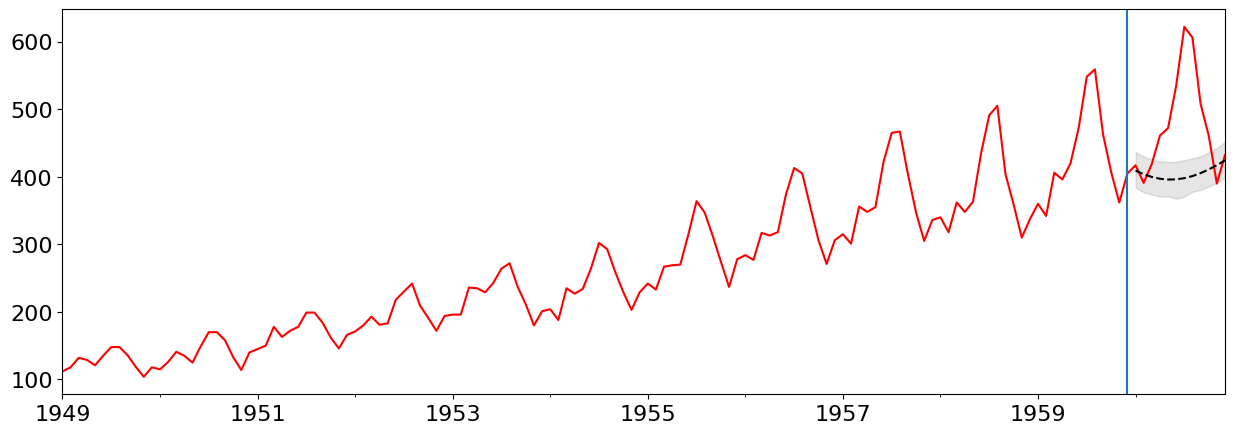

In [195]:
fcast = forecast.tail(12).rename(
    columns={
        "yhat": "mean", "yhat_lower": "mean_ci_lower", "yhat_upper": "mean_ci_upper"
    }
).tail(12)
fcast.index = y.tail(12).index

plot_forecast(fcast)